# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

When finished, you can close the environment.

In [5]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
# some needed libraries
import random
from collections import namedtuple, deque

In [7]:
#constants and hyperparams
# test with changing G,T,LR mainly, eps values pretty standard for this kind of task, experiment maybe

BUFFER_SIZE = int(1e5)  # replay buffer
BATCH_SIZE = 64         # minibatch size
G = 0.99                # gamma - discount factor
T = 2e-3                # tau - soft update factor
LR = 7e-4               # learning rate
UPDATE_FREQUENCY = 4    # how often to update the network
N_EPISODES = 1000       # must solve within this window
EPS_START = 1.          # epsilon greedy params: start, end decay
EPS_END = 0.01
EPS_DECAY = 0.995
MAX_STEPS = 1000        # don't wait until env return done, exit training loop if not done within MAX_STEPS
WINDOW_LENGTH = 100     # average score over last x episodes

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# models the q deep learning network
# experiment with number of layers and layer size to optimize convergence
# also experiment with externalizing the network shape to the caller layer -> later

class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fullyconnected1 = nn.Linear(state_size, 128)
        self.fullyconnected2 = nn.Linear(128, 64)
        self.fullyconnected3 = nn.Linear(64, 32)
        self.fullyconnected4 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.relu(self.fullyconnected1(state))
        x = F.relu(self.fullyconnected2(x))
        x = F.relu(self.fullyconnected3(x))
        return self.fullyconnected4(x)
    

In [9]:
class ReplayMemory(object):

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Exp",
                                     field_names=["state", "action", "reward",
                                                  "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        # build the output tuple, make sure no null values
        states = torch.from_numpy(np.vstack([e.state for e in experiences
                                  if e is not None])).float().to("cpu")
        actions = torch.from_numpy(np.vstack([e.action for e in experiences
                                   if e is not None])).long().to("cpu")
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences
                                   if e is not None])).float().to("cpu")
        next_states = torch.from_numpy(np.vstack([e.next_state
                                                  for e in experiences
                                                  if e is not None])).float().to("cpu")
        dones = torch.from_numpy(np.vstack([e.done for e in experiences
                                            if e is not None]).astype(np.uint8)).float().to("cpu")

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)


In [10]:
class DQAgent():

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        #replace cpu with gpu is system permits
        self.qnet = QNetwork(state_size, action_size, seed).to("cpu")
        self.target_qnet = QNetwork(state_size, action_size, seed).to("cpu")
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=LR)

        self.memory = ReplayMemory(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.time_step = self.time_step + 1
        if (self.time_step % UPDATE_FREQUENCY) == 0: # reached an update point, time to learn
            self.time_step = 0
            if len(self.memory) > BATCH_SIZE: # train
                experiences = self.memory.sample()
                self.learn(experiences, G)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to("cpu")
        self.qnet.eval()
        with torch.no_grad():
            action_values = self.qnet(state)
        self.qnet.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        max_Q = self.target_qnet(next_states).detach().max(1)[0].unsqueeze(1)
        Q_target = rewards + (gamma * max_Q * (1 - dones))
        Q_expected = self.qnet(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()  
        loss.backward() #backward prop
        self.optimizer.step()
        self.soft_update(self.qnet, self.target_qnet, T)

    def soft_update(self, local_model, target_model, tau):
        params = zip(target_model.parameters(), local_model.parameters())
        for target_param, local_param in params:
            tensor_aux = tau*local_param.data + (1.0-tau)*target_param.data
            target_param.data.copy_(tensor_aux)


In [11]:
#START THE TRAINING
# reset the environment, set training mode
env_info = env.reset(train_mode=True)[brain_name]
# initialize values
action_size = brain.vector_action_space_size
state_size = len(state)

In [12]:
scores = []                                # scores from each episode
last_scores = deque(maxlen=WINDOW_LENGTH)  # for saving last x scores
eps = EPS_START                            # epsilon greedy              

In [13]:
#instantiate the agent
agent = DQAgent(state_size=state_size, action_size=action_size, seed=0)

In [14]:
for episode in range(1, N_EPISODES+1):
    env_info = env.reset(train_mode=True)[brain_name] 
    state = env_info.vector_observations[0]            
    score = 0                                          
    for t in range(MAX_STEPS):
        action = agent.act(state, eps)
        env_info = env.step(action)[brain_name]        # execute action
        next_state = env_info.vector_observations[0]   
        reward = env_info.rewards[0]
        score += reward
        done = env_info.local_done[0]                  
        agent.step(state, action, reward, next_state, done)
        state = next_state                             
        if done:                                       # exit loop if episode finished
            break
    last_scores.append(score)       # save most recent score
    scores.append(score)              
    eps = max(EPS_END, EPS_DECAY*eps) 
    print('\rEpisode {} - average score: {:.2f}'.format(episode, np.mean(last_scores)), end="")
    if np.mean(last_scores)>=13.0:
        end_msg = '\nEnvironment solved in {:d} episodes, average score: {:.2f}'
        print(end_msg.format(episode, np.mean(last_scores)))
        break


Episode 469 - average score: 13.04
Environment solved in 469 episodes, average score: 13.04


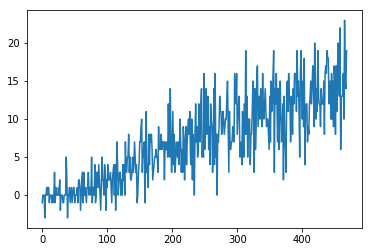

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

s = np.array(scores)
plt.plot(np.arange(len(s)), s)